## Heart Attack Prediction Model  
## Advanced Modeling - Hyperparameters Tuning, Final Model Training 
## Neural Network - 
## Evaluation & Summary
---


## Author: Will Wu

## Date: 2025-03-21
---

## Introduction
This notebook is composed of five main sections:

---

## **Table of Contents** ##
1. [Setup and Load Data](#1)
2. [Data Preparation](#2)
3.  [Additional EDA: Addressing Missing Values](#3)
    - [Missing Values Analysis](#3a)
       - [height](#3a1)
       - [weight](#3a2)
       - [physical_health_days](#3a3)
       - [pneumo_vax and flu_vax](#3a4)
    - [Summary](#3b)
     
4. [Data Cleaning and Export - Stage 2](#4)
    - [height](#4a)
    - [weight](#4b)
    - [bmi](#4c)
    - [physical_health_days](#4d)
    - [pneumo_vax and flu_vax](#4e)
    - [Data Quality Check](#4f)
    - [Export](#4g)

---

## 1. Setup and Loading<a class="anchor" id="1"></a>

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  roc_auc_score, roc_curve
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pickle
from model_evaluator import ModelEvaluator
from resampler import UpSampler, DownSampler


In [2]:
# Configure Seaborn to use 'darkgrid' as the default background style
sns.set_style('darkgrid')

# Create a default palette
palette = sns.color_palette("muted")

# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6.0, 6.0)

# Filter warnings 
from warnings import filterwarnings
filterwarnings(action='ignore')

In [3]:
# Load X, X_fs(with feature selection), and y
df_original = pd.read_csv('../data/processed/df_original.csv')
df_selected = pd.read_csv('../data/processed/df_feature_selected.csv')

In [4]:
# Check shape
print(f'The shape of original DataFrame without feature selection is: {df_original.shape}')
print(f'The shape of feature-selected DataFrame is: {df_selected.shape}')

The shape of original DataFrame without feature selection is: (751985, 38)
The shape of feature-selected DataFrame is: (751985, 20)


---

## 2. Data Preparation <a class="anchor" id="2"></a>

Create X and y on selected features

In [5]:
# Get X and y
X = df_selected[[col for col in df_selected.columns if col != 'had_heart_attack']]
y = df_selected['had_heart_attack']

---

Train Test Split

In [6]:
# remainder, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

In [7]:
# Create sample for X_train, y_train
X_sample = X_train.sample(frac=0.3, random_state=1)
y_sample = y_train[X_sample.index]

# Print size for sanity check
print(f'The size of X_sample is {X_sample.shape}')
print(f'The size of y_sample is {y_sample.shape}')
print(f'The value counts (%) in y_sample is: {y_sample.value_counts(normalize=True).round(4) * 100}')

The size of X_sample is (169196, 19)
The size of y_sample is (169196,)
The value counts (%) in y_sample is: had_heart_attack
0    94.72
1     5.28
Name: proportion, dtype: float64


---

Create ColumnTransformer for One Hot Encoding

In [8]:
# Get categorial and numeric features
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include='number').columns.tolist()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_cols', OneHotEncoder(sparse_output=False), categorical_features),  # Apply OneHotEncoder to categorical features
        ('num_cols', 'passthrough', numeric_features)         # Keep numeric features untouched
    ]
)

I will build a pipeline that incorporates resampling, one-hot encoding, and scaling. With these preprocessing steps in place, I will proceed to explore different models for hyperparameter tuning and finalize model selection.

---

## 3. Logistic Regression <a class="anchor" id="3"></a>

### 3.1 Grid Search <a class="anchor" id="3a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [9]:
# Create the pipeline for grid search using logistic regression
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [10]:
# Create hyperparameter grid for logistic regression
params_grid = {
    'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga', 'liblinear'],
}

Hyperparameter grid search for optimal recall score

In [11]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [12]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [13]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of logistic regression for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of logistic regression for optimal recall score: 


{'logreg__C': 0.0001, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}

The best hyperparameters for logistic regression with optimimal recall score are: C=0.001, penalty=l2, solver=saga. 

---

### 3.2 Train the model <a class="anchor" id="3b"></a>

In [14]:
# Create pipeline using the optimal hyperparameters
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=0.001, penalty='l2' ,solver='saga', random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train) 

Pipeline(steps=[('downsampler',
                 <resampler.DownSampler object at 0x000001F74036B610>),
                ('encoding',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['race_ethnicity_category',
                                                   'age_category',
                                                   'bmi_category',
                                                   'alcohol_drinkers',
                                                   'general_health',
                                                   'smoker_status', 'had_copd',
                                                   'had_diabetes',
                                                   'had_kidney_disease',
                                                   'had_depressive_disorder',
                                                   'had_arthritis',
                                                   'deaf_or_hard_of_hearing',
                                                   'blind_or_vision_difficulty',
                                                   'difficulty_walking',
                                                   'difficulty_dressing_bathing']),
                                                 ('num_cols', 'passthrough',
                                                  ['is_female',
                                                   'physical_activities',
                                                   'had_angina',
                                                   'had_stroke'])])),
                ('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001, random_state=42, solver='saga'))])

---

### 3.3 Model Evaluation <a class="anchor" id="3c"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

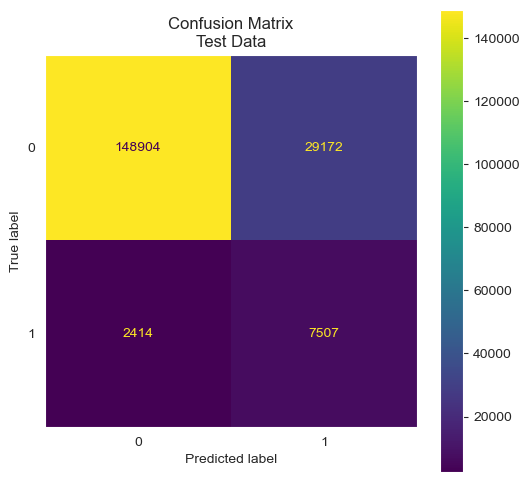

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.20      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.758
Test: 0.757 
False Positive Rate:
Train: 0.163
Test: 0.164 
AUC Score:
Train: 0.884
Test: 0.881 
Accuracy Score:
Train: 0.833
Test: 0.832 
Precision Score:
Train: 0.206
Test: 0.205 
F1 Score:
Train: 0.324
Test: 0.322 


In [15]:
# Use self-built ModelEvaluator to evaluate the mode
evaluator = ModelEvaluator(pipeline)
evaluator.evaluate(X_train, X_test, y_train, y_test)

ROC Curve: Logistic Regression


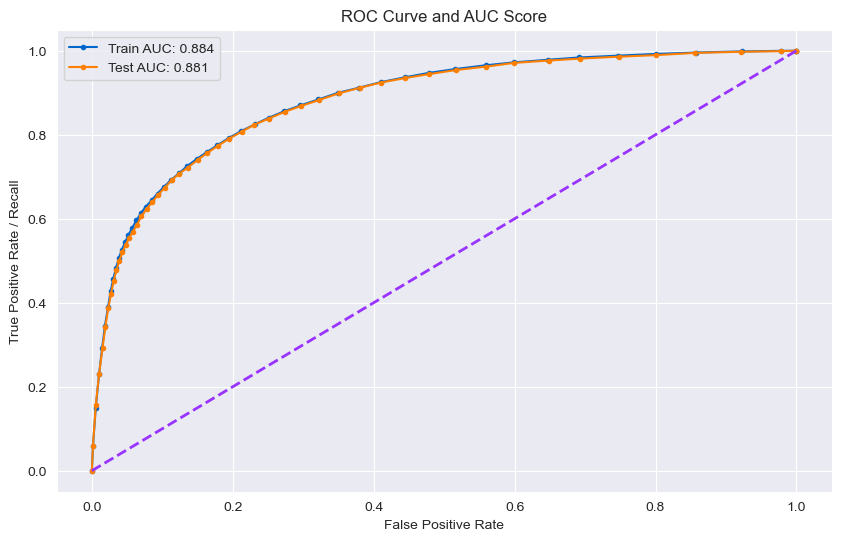

In [16]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: Logistic Regression')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

---

### 3.4 Adjust Threshold  <a class="anchor" id="3d"></a>


Identify thresholds where the recall on the test set is greater than or equal to 0.80, and re-evaluate the model using the updated thresholds.

In [17]:
# Create variable for target recall score
target_recall = 0.80

# Get the probablistic prediction on test dataset
y_pred_test = pipeline.predict_proba(X_test)[:, 1]  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

For recall score to reach the target of 0.80, the threshold should be updated to: 0.4487


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

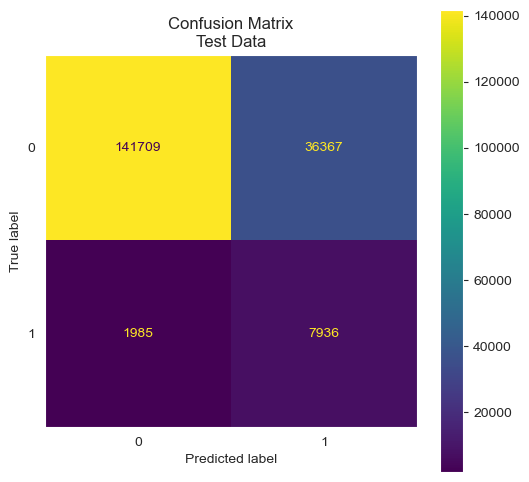

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.80      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.801
Test: 0.800 
False Positive Rate:
Train: 0.204
Test: 0.204 
AUC Score:
Train: 0.884
Test: 0.881 
Accuracy Score:
Train: 0.796
Test: 0.796 
Precision Score:
Train: 0.180
Test: 0.179 
F1 Score:
Train: 0.293
Test: 0.293 


In [18]:
# Re-evaluate the model using the new threshold
evaluator = ModelEvaluator(pipeline)
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

### 3.5 Logistic Regression Model Summary <a class="anchor" id="4a"></a>

**Metrics using test data:**
random_state=42, no PCA

| Model       | Resample Method | Threshold | Recall | FPR   | AUC   | Accuracy | Precision | F1 Score | Hyperparameters                      | Notes                    |
|-------------|------------------|-----------|--------|-------|-------|----------|-----------|----------|--------------------------------------|--------------------------|
| Logistic Regression   | Downsampling     | 0.4487      | 0.800   | 0.204  | 0.881  | 0.796     | 0.179      | 0.293     |  C=0.001, penalty=l2, solver=saga  | Final       |


---

## 4. Naive Bayes <a class="anchor" id="4"></a>

### 4.1 Grid Search <a class="anchor" id="4a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [234]:
# Create the pipeline for grid search using naive bayes
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('nb' , GaussianNB())
])

In [235]:
# Create params for naive bayes
params_grid = {
    'nb__var_smoothing': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}

In [236]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [237]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [238]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of naive bayes for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of naive bayes for optimal recall score: 


{'nb__var_smoothing': 0.001}

The best hyperparameters for naive bayes with optimimal recall score are: var_smoothing = 0.001 

---

### 4.2 Train the model <a class="anchor" id="4b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

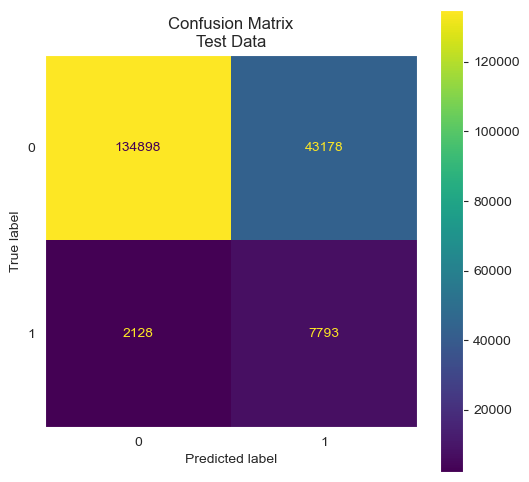

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.76      0.86    178076
           1       0.15      0.79      0.26      9921

    accuracy                           0.76    187997
   macro avg       0.57      0.77      0.56    187997
weighted avg       0.94      0.76      0.82    187997

Recall Score:
Train: 0.786
Test: 0.786 
False Positive Rate:
Train: 0.241
Test: 0.242 
Accuracy Score:
Train: 0.760
Test: 0.759 
Precision Score:
Train: 0.154
Test: 0.153 
F1 Score:
Train: 0.257
Test: 0.256 
AUC Score:
Train: 0.837
Test: 0.835 


In [42]:
# Create pipeline using the optimal hyperparameters
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('nb' , GaussianNB(var_smoothing= 0.001))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Use self-built ModelEvaluator to evaluate the mode
evaluator = ModelEvaluator(pipeline)
evaluator.evaluate(X_train, X_test, y_train, y_test)

## 5. Decision Tree <a class="anchor" id="5"></a>

### 5.1 Grid Search <a class="anchor" id="5a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [245]:
# Create the pipeline for grid search using logistic regression
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier())
])

In [246]:
# Create hyperparameter grid for logistic regression
params_grid = {
    'dtc__max_depth': [3, 7, 12, 18],
    'dtc__min_samples_split': [2, 5, 10, 20, 40],
    'dtc__min_samples_leaf': [15, 30, 75, 100],
    'dtc__criterion': ['gini', 'entropy']
}

In [247]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [248]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [249]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'dtc__criterion': 'entropy',
 'dtc__max_depth': 12,
 'dtc__min_samples_leaf': 75,
 'dtc__min_samples_split': 10}

Phase 2 - Conduct hyperparameter grid search with a refined and narrower range of values

In [250]:
# Create the pipeline for grid search using logistic regression
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(criterion='entropy'))
])

In [251]:
# Create hyperparameter grid for logistic regression
params_grid = {
    'dtc__max_depth': [10, 12, 13, 14],
    'dtc__min_samples_split': [8, 10, 12, 14],
    'dtc__min_samples_leaf': [60, 75, 90],
}

In [252]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [253]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [254]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'dtc__max_depth': 12,
 'dtc__min_samples_leaf': 75,
 'dtc__min_samples_split': 8}

The best hyperparameters for decision tree with optimimal recall score are: max_depth=12, min_samples_split=8, min_samples_leaf=75, criterion=entropy

---

### 5.2 Train the model <a class="anchor" id="5b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

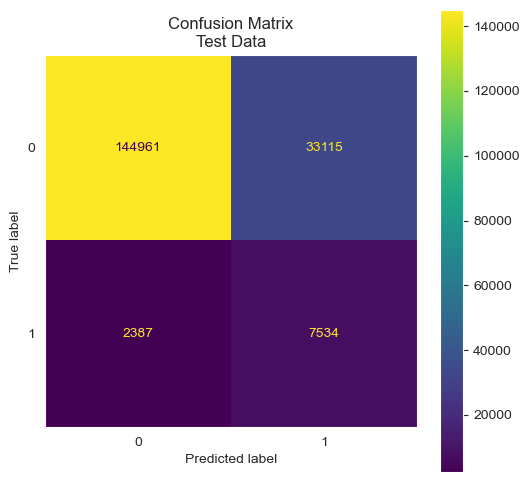

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.19      0.76      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.58      0.79      0.59    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.776
Test: 0.759 
False Positive Rate:
Train: 0.185
Test: 0.186 
Accuracy Score:
Train: 0.813
Test: 0.811 
Precision Score:
Train: 0.189
Test: 0.185 
F1 Score:
Train: 0.304
Test: 0.298 
AUC Score:
Train: 0.879
Test: 0.871 


In [257]:
# Create pipeline using the optimal hyperparameters
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(max_depth=12, 
                                  min_samples_split=8,
                                  min_samples_leaf=75, 
                                  criterion='entropy'))
])

# Fit the model
pipeline.fit(X_train, y_train) 

# Use self-built ModelEvaluator to evaluate the mode
evaluator = ModelEvaluator(pipeline)
evaluator.evaluate(X_train, X_test, y_train, y_test)

## 6. Random Forest <a class="anchor" id="6"></a>

### 6.1 Grid Search <a class="anchor" id="6a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [225]:
# Create the pipeline for grid search using logistic regression
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

Phase 1 - Initial hyperparameter grid search for optimal recall score

In [226]:
# Create hyperparameter grid for random_forest
params_grid = {
    'rfc__n_estimators': [50, 100, 150],
    'rfc__max_depth': [7, 10, 15],
    'rfc__min_samples_split': [5, 15, 30, 70],
    'rfc__min_samples_leaf': [15, 50, 100],
    'rfc__bootstrap': [True, False]
}

In [227]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [228]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [229]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of random forest for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of random forest for optimal recall score: 


{'rfc__bootstrap': False,
 'rfc__max_depth': 15,
 'rfc__min_samples_leaf': 100,
 'rfc__min_samples_split': 15,
 'rfc__n_estimators': 50}

Phase 2 - Conduct hyperparameter grid search with a refined and narrower range of values

In [ ]:
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(bootstrap=True))
])

In [214]:
# Create hyperparameter grid for random_forest
params_grid = {
    'rfc__n_estimators': [80, 100, 120],
    'rfc__max_depth': [12, 15, 18],
    'rfc__min_samples_split': [4, 5, 6, 7],
    'rfc__min_samples_leaf': [80, 100, 120]
}

In [216]:
# Create GridSearch CV, set scoring as recall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [217]:
# Fit using X_sample and y_sample
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [218]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of random forest for optimal recall: ")
fitted_grid_recall.best_params_

The hyperparameters of random forest for optimal recall: 


{'rfc__max_depth': 15,
 'rfc__min_samples_leaf': 80,
 'rfc__min_samples_split': 6,
 'rfc__n_estimators': 80}

The best hyperparameters for random forst with optimimal recall score are: max_depth=15, min_samples_leaf=80, min_samples_split=6, n_estimators=80, bootstrap=True

---

### 6.2 Train the model <a class="anchor" id="6b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

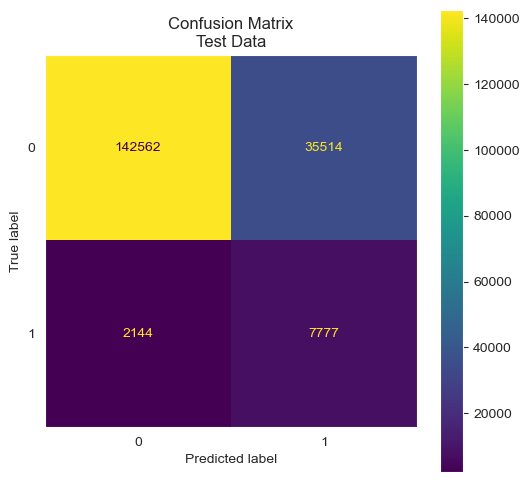

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.78      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.79      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.791
Test: 0.784 
False Positive Rate:
Train: 0.199
Test: 0.199 
Accuracy Score:
Train: 0.800
Test: 0.800 
Precision Score:
Train: 0.181
Test: 0.180 
F1 Score:
Train: 0.295
Test: 0.292 
AUC Score:
Train: 0.881
Test: 0.877 


In [224]:
# Create pipeline using the optimal hyperparameters
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(
        n_estimators=80,
        max_depth=15,
        min_samples_leaf=80,
        min_samples_split=6,
        bootstrap=True
    ))
])

# Fit the model
pipeline.fit(X_train, y_train) 

# Use self-built ModelEvaluator to evaluate the mode
evaluator = ModelEvaluator(pipeline)
evaluator.evaluate(X_train, X_test, y_train, y_test)

## 7. XGBoost <a class="anchor" id="7"></a>

### 7.1 Grid Search <a class="anchor" id="7a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [92]:
# Create the pipeline for grid search using logistic regression
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

In [99]:
# Create hyperparameter grid for XGBoost
params_grid = {
    'xgb__n_estimators': [50, 100],         
    'xgb__learning_rate': [0.05, 0.1],       
    'xgb__max_depth': [3, 5, 7, 11, 13, 15],             
    'xgb__min_child_weight': [1, 5],         
    'xgb__subsample': [0.8, 1.0],  
}

In [100]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [101]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [102]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 7,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.8}

In [104]:
params_grid = {
    'xgb__n_estimators': [80, 100, 120],         
    'xgb__learning_rate': [0.08, 0.1, 0.12],       
    'xgb__max_depth': [6, 7, 8, 9],             
    'xgb__min_child_weight': [4, 5, 6],         
    'xgb__subsample': [0.7, 0.8, 0.9],  
}

In [105]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [107]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

[13:54:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "min_subsample" } are not used.



In [111]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 7,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.8}

The best hyperparameters for decision tree with optimimal recall score are: max_depth=11, min_samples_split=2, min_samples_leaf=80, criterion=entropy

---

### 7.2 Train the model <a class="anchor" id="7b"></a>

[13:39:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "min_subsample" } are not used.

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

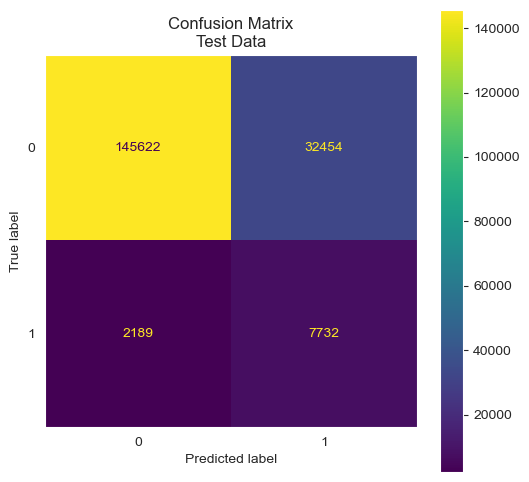

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.82      0.89    178076
           1       0.19      0.78      0.31      9921

    accuracy                           0.82    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.82      0.86    187997

Recall Score:
Train: 0.794
Test: 0.779 
False Positive Rate:
Train: 0.181
Test: 0.182 
Accuracy Score:
Train: 0.817
Test: 0.816 
Precision Score:
Train: 0.196
Test: 0.192 
F1 Score:
Train: 0.315
Test: 0.309 
AUC Score:
Train: 0.892
Test: 0.882 


In [103]:
# Create pipeline using the optimal hyperparameters
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        n_estimators=100,
        max_depth=7,
        min_child_weight=5,
        min_subsample=0.8,
        learning_rate=0.1
    ))
])

# Fit the model
pipeline.fit(X_train, y_train) 

# Use self-built ModelEvaluator to evaluate the mode
evaluator = ModelEvaluator(pipeline)
evaluator.evaluate(X_train, X_test, y_train, y_test)

## 8. Neural Network <a class="anchor" id="8"></a>

In [54]:
# Split the X_train, y_train into train and validation set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1)

In [55]:

preprocess_pipe = Pipeline([
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler())
])

X_train_nn = preprocess_pipe.fit_transform(X_train_nn)
X_val_nn = preprocess_pipe.transform(X_val_nn)


In [56]:
# Get the percentage of each class in y
class0_pct = pd.Series(y).value_counts(normalize=True)[0]
class1_pct = pd.Series(y).value_counts(normalize=True)[1]

# Calculate the weight for class0 and class1
class0_weight = 1 / class0_pct
class1_weight = 1 / class1_pct

# Calculate the total weights
total_weight = class0_weight + class1_weight

# Get class weights for neural network training
class_weights = {
    0 : class0_weight / total_weight * 2,
    1 : class1_weight / total_weight * 2
}

In [57]:
# Features
X_train_nn = np.asarray(X_train_nn).astype('float32')
X_val_nn = np.asarray(X_val_nn).astype('float32')

# Labels
y_train_nn = np.asarray(y_train_nn).ravel()
y_val_nn = np.asarray(y_val_nn).ravel()

In [58]:
def recall_fpr_loss(y_true, y_pred, recall_target=0.85, fpr_weight=0.5):
    """
    Custom loss for recall targeting and FPR minimization.
    
    Args:
        recall_target: Stop pushing recall beyond this value (0.85)
        fpr_weight: Relative importance of FPR reduction (0.5-2.0 recommended)
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    
    # Base binary cross-entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Get positive/negative predictions
    pos_mask = tf.equal(y_true, 1.0)
    neg_mask = tf.equal(y_true, 0.0)
    y_pos = tf.boolean_mask(y_pred, pos_mask)
    y_neg = tf.boolean_mask(y_pred, neg_mask)
    
    # 1. Recall component (target-aware hinge loss)
    recall_term = tf.cond(
        tf.size(y_pos) > 0,
        lambda: tf.reduce_mean(tf.maximum(recall_target - y_pos, 0)),
        lambda: 0.0
    )
    
    # 2. FPR component (penalize high negative predictions)
    fpr_term = tf.cond(
        tf.size(y_neg) > 0,
        lambda: tf.reduce_mean(y_neg),  # Directly minimize mean negative predictions
        lambda: 0.0
    )
    
    # 3. Combined loss with dynamic weighting
    return bce + recall_term + fpr_weight * fpr_term

In [66]:
# Set up the structure 
# nn_model = Sequential([
#     Dense(10, activation="relu"),   # Add hidden layer
#     Dense(10, activation="relu"),   # Add hidden layer
#     Dense(10, activation="relu"),   # Add hidden layer
#     Dense(1, activation='sigmoid')  # Output layer
# ])
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

nn_model = Sequential([
    # Input layer with 90 features
    Dense(128, activation='relu', input_shape=(70,), 
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu', 
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')  # Binary output
])

# Adaptive learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


# Compile the model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(),
    # loss=recall_fpr_loss,
    metrics=[
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'), 
        keras.metrics.Recall(name='recall'),      # Monitoring recall
        keras.metrics.FalsePositives(name='fp')  # Monitoring false positives
    ]
)


# Create early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_pr_auc', patience=10, restore_best_weights=True)

In [67]:
# Fit the model
history = nn_model.fit(
    X_train_nn,
    y_train_nn,
    class_weight = class_weights,
    epochs=100,
    batch_size=512,
    verbose=1,
    validation_data=(X_val_nn, y_val_nn), 
    callbacks=[early_stopping]  # Set up early stopping to prevent overfitting
)

Epoch 1/100
882/882 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - fp: 80931.8281 - loss: 0.3390 - pr_auc: 0.1608 - recall: 0.7164 - val_fp: 22673.0000 - val_loss: 0.6895 - val_pr_auc: 0.3542 - val_recall: 0.7782
Epoch 2/100
882/882 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - fp: 50517.5547 - loss: 0.2609 - pr_auc: 0.3129 - recall: 0.7755 - val_fp: 18128.0000 - val_loss: 0.5876 - val_pr_auc: 0.3793 - val_recall: 0.7576
Epoch 3/100
882/882 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - fp: 42959.2227 - loss: 0.2184 - pr_auc: 0.3380 - recall: 0.7632 - val_fp: 17253.0000 - val_loss: 0.5253 - val_pr_auc: 0.3856 - val_recall: 0.7525
Epoch 4/100
882/882 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - fp: 40786.9727 - loss: 0.1871 - pr_auc: 0.3560 - recall: 0.7642 - val_fp: 18245.0000 - val_loss: 0.4939 - val_pr_auc: 0.3903 - val_recall: 0.7690
Epoch 5/100
882/882 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - fp: 41526.8242 - loss: 0.1635 - pr_auc: 0.3658 - recall: 0.7723 - val_fp: 18257.0000 - val_loss: 0.4728 - val_pr_auc: 0.3943 - val_recall: 0.

In [68]:
X_test = preprocess_pipe.transform(X_test)

ValueError: X has 70 features, but ColumnTransformer is expecting 19 features as input.

14100/14100 ━━━━━━━━━━━━━━━━━━━━ 9s 626us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 4s 610us/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

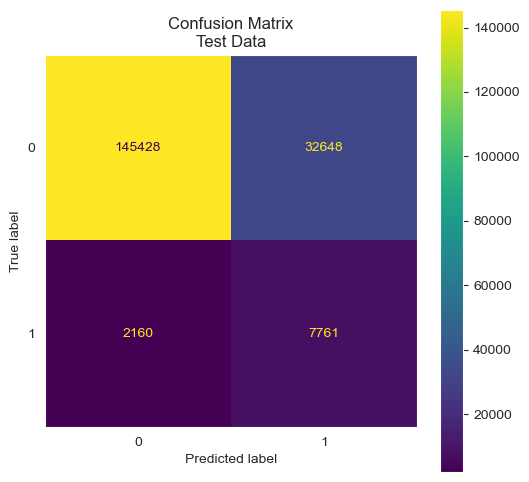

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.82      0.89    178076
           1       0.19      0.78      0.31      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.795
Test: 0.782 
False Positive Rate:
Train: 0.183
Test: 0.183 
Accuracy Score:
Train: 0.816
Test: 0.815 
Precision Score:
Train: 0.195
Test: 0.192 
F1 Score:
Train: 0.314
Test: 0.308 
AUC Score:
Train: 0.892
Test: 0.883 


In [69]:
evaluator = ModelEvaluator(nn_model, is_neural_network=True)
evaluator.evaluate(X_train_nn, X_test, y_train_nn, y_test)


In [75]:
# Create variable for target recall score
target_recall = 0.85

# Get the probablistic prediction on test dataset
y_pred_test = nn_model.predict(X_test).flatten()  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.85, the threshold should be updated to: {model_threshold:.4f}')
        break

5875/5875 ━━━━━━━━━━━━━━━━━━━━ 4s 685us/step
For recall score to reach the target of 0.85, the threshold should be updated to: 0.4127


14100/14100 ━━━━━━━━━━━━━━━━━━━━ 9s 623us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 4s 599us/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

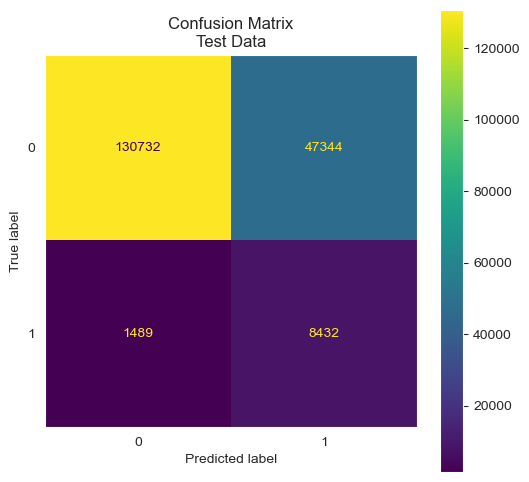

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.73      0.84    178076
           1       0.15      0.85      0.26      9921

    accuracy                           0.74    187997
   macro avg       0.57      0.79      0.55    187997
weighted avg       0.94      0.74      0.81    187997

Recall Score:
Train: 0.862
Test: 0.850 
False Positive Rate:
Train: 0.265
Test: 0.266 
Accuracy Score:
Train: 0.742
Test: 0.740 
Precision Score:
Train: 0.153
Test: 0.151 
F1 Score:
Train: 0.260
Test: 0.257 
AUC Score:
Train: 0.892
Test: 0.883 


In [77]:
# Re-evaluate the model using the new threshold
evaluator = ModelEvaluator(nn_model, is_neural_network=True)
evaluator.evaluate(X_train_nn, X_test, y_train_nn, y_test, thresholds=model_threshold)